### Clustering Similar Players

In [1]:
# packages and file import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# wd
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [2]:
data_02_24 = pd.read_csv('./data/cleaned/data_02_24.csv')
data_15_24 = pd.read_csv('./data/cleaned/data_15_24.csv')

fix cols

In [3]:
data_02_24 = data_02_24.drop(columns=['Unnamed: 0', 'Team'])
data_15_24 = data_15_24.drop(columns=['Unnamed: 0', 'Team'])
df = data_15_24.copy()
df = df.dropna(axis=1)
df = df[df['PA'] > 100]

#### Normalization
<small> all code standard across ipynb when normalization is required (I should probably refactor into .py lol)

In [4]:
def mean_year(group):
        avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
        return avg

In [5]:
def calculate_weighted_std(group):
    avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    variance = np.average((group - avg)**2, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    return np.sqrt(variance)

In [6]:
def z_scores(player_df, mean_df, std_df):
    # z scores for each stat and player, also creating a new df flow, add back names based on MLBAMID later
    z_scores = pd.DataFrame(index=player_df.index, columns=player_df.select_dtypes(include=[np.number]).columns)

    # scaled for each col
    for col in player_df.select_dtypes(include=[np.number]).columns:
        if col not in ['Season', 'MLBAMID']:  # not needed
            for idx in player_df.index:
                season = player_df.loc[idx, 'Season']
                value = player_df.loc[idx, col]
                mean = mean_df.loc[mean_df['Season'] == season, col].iloc[0]
                std = std_df.loc[std_df['Season'] == season, col].iloc[0]
                # scale so that 10 is 1 std away
                z_scores.loc[idx, col] = 100 + ((value - mean) / std * 10)

    z_scores['Season'] = player_df['Season']
    
    # cols to numeric
    for col in z_scores.columns:
        if col not in ['Season', 'MLBAMID']:
            z_scores[col] = pd.to_numeric(z_scores[col])
    
    # reinsert player names
    z_scores.insert(0, 'Name', player_df['Name']) 

    return z_scores

In [7]:
# df to store mean results
mean_values = pd.DataFrame(index=df['Season'].unique())

for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_mean = df.groupby('Season')[col].apply(mean_year)
        mean_values[col] = yearly_mean

# reset and rename index
mean_values = mean_values.reset_index()
mean_values = mean_values.rename(columns={'index': 'Season'})

# sort and display
mean_values = mean_values.sort_values(by=['Season'])
mean_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,...,Barrel%,maxEV,HardHit%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
0,2015,473.000807,28.406830,0.078561,0.196159,0.302323,101.703441,0.109003,3.326956,-0.555203,...,0.051987,110.141662,0.342330,0.306820,0.675174,0.656059,0.872782,0.795164,0.096545,0.263119
1,2016,481.366746,28.519147,0.083881,0.203510,0.302725,101.917382,0.051932,4.103679,-0.795624,...,0.060926,110.415648,0.353323,0.303360,0.671929,0.646008,0.867408,0.787936,0.099088,0.265533
2,2017,476.786961,28.345259,0.087652,0.208815,0.302744,101.937393,0.057559,3.652319,-0.729389,...,0.061091,110.222937,0.343395,0.298602,0.672624,0.635855,0.859684,0.781037,0.102645,0.268009
3,2018,471.915997,28.115974,0.086914,0.214215,0.298732,101.714562,0.148301,3.795978,-0.958030,...,0.066110,110.463651,0.362899,0.309133,0.679535,0.636317,0.860804,0.776377,0.105250,0.270896
4,2019,464.914972,27.950325,0.087278,0.220105,0.300689,102.210402,0.093780,4.359199,-0.832427,...,0.072297,110.588608,0.374544,0.316182,0.692080,0.633711,0.854930,0.769328,0.109512,0.270603


In [8]:
# Create empty DataFrame to store results
std_values = pd.DataFrame(index=df['Season'].unique())

# Loop through numeric columns
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_std = df.groupby('Season')[col].apply(calculate_weighted_std)
        std_values[col] = yearly_std

std_values = std_values.reset_index()
std_values = std_values.rename(columns={'index': 'Season'})

std_values = std_values.sort_values(by=['Season'])
std_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,...,Barrel%,maxEV,HardHit%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
0,2015,165.937131,3.920175,0.030939,0.057592,0.037114,27.346927,3.263287,15.699682,8.380724,...,0.036316,3.140128,0.082114,0.056871,0.059338,0.089534,0.049212,0.059221,0.031697,0.027038
1,2016,171.285879,3.939726,0.030104,0.059157,0.036182,25.015749,2.717802,14.769137,9.410718,...,0.037048,3.369109,0.078093,0.055723,0.057835,0.088766,0.048051,0.058334,0.030790,0.026258
2,2017,160.880361,3.820437,0.032471,0.061165,0.036608,25.958521,2.727740,15.733877,8.659952,...,0.038383,3.490023,0.077479,0.058800,0.057204,0.087512,0.049874,0.060109,0.032000,0.028312
3,2018,163.940483,3.703694,0.031847,0.060666,0.037349,26.519238,2.519796,15.510276,8.723117,...,0.037651,3.395719,0.077966,0.061093,0.058005,0.085400,0.048408,0.058746,0.031973,0.028248
4,2019,164.230152,3.666218,0.031678,0.060823,0.037735,27.166508,2.406099,16.262761,8.849027,...,0.039366,3.355495,0.075813,0.061697,0.059757,0.088034,0.047627,0.058396,0.032008,0.028158


In [9]:
df_zscore = z_scores(df, mean_df=mean_values, std_df=std_values)
df_zscore.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,Barrel%,maxEV,HardHit%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
0,aaron altherr,2015,81.197650,88.758588,106.728812,110.157560,99.663901,108.281754,102.880918,101.458941,...,91.247739,99.631664,111.205531,88.289787,92.748111,87.764672,100.594162,95.423451,99.705471,107.032104
1,aaron altherr,2016,85.149579,91.067534,105.793491,116.980938,95.930300,84.821145,98.809770,90.212836,...,91.924398,103.785427,99.425572,93.647390,94.428432,86.816714,92.509824,89.522559,105.924618,115.299310
2,aaron altherr,2017,95.972973,93.861281,96.925894,107.130264,106.898873,106.849736,95.644590,103.596516,...,109.265288,105.842550,111.336219,97.640806,93.793172,86.779711,94.135434,90.137003,106.569011,113.317089
3,aaron altherr,2018,88.598545,96.986862,112.372063,117.321778,86.035152,89.546542,101.887744,92.120333,...,108.311301,112.287087,111.754754,93.497407,100.897211,74.445289,94.224099,85.487124,110.407999,114.134229
5,aaron hicks,2015,94.998057,91.309495,102.785780,95.324366,95.386134,97.828088,100.982365,96.936795,...,93.333819,92.635135,98.904352,88.448499,102.169352,97.027102,100.881173,101.523409,96.911449,92.821100


#### Player Avg Data

clean player names

In [10]:
# borrowed from player att ipynb
def clean_names(df):
    df['Name'] = df['Name'].str.split(',').str[0]
    df['Name'] = df['Name'].str.replace(r'[^a-z\s]', '', regex=True)
    return df

group by player, weighted mean for player

In [11]:
# clean names
df_player = clean_names(df_zscore)
df_player = df_player.drop(columns=['Season'])

# df to store mean results
df_zscore_mean = pd.DataFrame()

# Loop through each group
for name, group in df_player.groupby('Name'):
    weighted_means = {}
    for col in group.select_dtypes(include=[np.number]).columns:
        if col != 'PA':  
            weighted_means[col] = np.average(group[col], weights=group['PA'])
    weighted_means['Name'] = name  
    df_zscore_mean = pd.concat([df_zscore_mean, pd.DataFrame([weighted_means])], ignore_index=True)


cols = ['Name'] + [col for col in df_zscore_mean.columns if col != 'Name']
df_zscore_mean = df_zscore_mean[cols]

#### Clustering Methods

In [12]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

##### KMeans

In [13]:
X = df_zscore_mean.drop(columns=['Age', 'wRC+', 'Name']) # dont include age 

wcss = []
for i in range(2,20):
    kmeans_clust = KMeans(n_clusters=i, init='k-means++', random_state=42)
    labels = kmeans_clust.fit_predict(X)
    score = silhouette_score(X, labels)
    wcss.append(score)

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

##### Spectral 'rbf'

In [14]:
X1 = df_zscore_mean.drop(columns=['Age', 'wRC+', 'Name']) # dont include age 
gamma = [0.0001 ,0.001, 0.01]
n_clusters = [2, 3, 4, 5, 6]

# training matrix to min silo score
para_matrix = pd.DataFrame(columns=['silo', 'gamma', 'clusters'])
i = 0
g = 0
for gamma in gamma:
    g += 1
    for cluster in n_clusters:
        i += 1
        spectral = SpectralClustering(n_clusters=cluster, 
                                      gamma=gamma,
                                      affinity='rbf', 
                                      assign_labels='kmeans',
                                      n_init=20,
                                      random_state=26)
        labels = spectral.fit_predict(X)
        loss_kinda = np.nan
        if (len(set(labels))) > 1:
            loss_kinda = silhouette_score(X, labels)
        para_matrix.loc[len(para_matrix)] = [loss_kinda, gamma, cluster]
        print(f"cluster {i}, gamma {g}, silo score {loss_kinda}")
       

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 1, gamma 1, silo score 0.22889445300781466


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 2, gamma 1, silo score 0.14260350048809686


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 3, gamma 1, silo score 0.13462487306631674


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 4, gamma 1, silo score 0.1019037133737978


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 5, gamma 1, silo score 0.07990917963092568


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 6, gamma 2, silo score 0.23088951781678635


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 7, gamma 2, silo score 0.1508473898767749


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 8, gamma 2, silo score 0.13276897841212276


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 9, gamma 2, silo score 0.11811115076522426


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 10, gamma 2, silo score 0.10810054428625229


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 11, gamma 3, silo score 0.3382938797169301


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 12, gamma 3, silo score 0.33724932637541327


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 13, gamma 3, silo score 0.3050020874208477


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 14, gamma 3, silo score 0.19479159905473864
cluster 15, gamma 3, silo score 0.1773540530158263


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


##### Spectral 'nearest neighbor'

In [15]:
n_clusters = [2, 3, 4, 5, 6]

# training matrix to min silo score
para_matrix_nmeans = pd.DataFrame(columns=['silo', 'gamma', 'clusters'])
i = 0
g = 0
for cluster in n_clusters:
        i += 1
        spectral = SpectralClustering(n_clusters=cluster, 
                                      affinity='nearest_neighbors', 
                                      assign_labels='kmeans',
                                      n_init=20,
                                      random_state=26)
        labels = spectral.fit_predict(X)
        loss_kinda = np.nan
        if (len(set(labels))) > 1:
            loss_kinda = silhouette_score(X, labels)
        para_matrix_nmeans.loc[len(para_matrix_nmeans)] = [loss_kinda, gamma, cluster]
        print(f"cluster {i}, gamma {g}, silo score {loss_kinda}")
        

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 1, gamma 0, silo score 0.22181923080619903


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 2, gamma 0, silo score 0.15136255460143674


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 3, gamma 0, silo score 0.13764538794825007


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 4, gamma 0, silo score 0.1329636018991764


c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster 5, gamma 0, silo score 0.12292696426742261


Player Clusters

In [16]:
model = SpectralClustering(n_clusters=2, 
                                      gamma=0.01,
                                      affinity='nearest_neighbors', 
                                      assign_labels='kmeans',
                                      n_init=100,
                                      random_state=40)
labels = model.fit_predict(X)

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


add to df_zscore

In [17]:
df_zscore_mean['Cluster'] = labels
df_zscore_mean.head()

,Name,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,...,maxEV,HardHit%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%,Cluster
0,aaron altherr,92.791828,105.245638,112.794092,97.295717,97.467260,99.663244,96.956934,101.297227,94.821392,...,105.533373,108.521560,93.462011,95.499103,83.902451,95.257828,90.037137,105.793776,112.550121,1
1,aaron hicks,102.164326,113.783688,99.037496,93.152391,99.980621,103.071443,99.743476,98.889636,97.801609,...,95.289220,98.083109,86.997798,95.001708,96.877947,94.138133,96.931995,97.997937,100.745961,0
2,aaron hill,112.838404,103.447632,90.633893,90.889066,91.806992,98.917058,91.760734,100.690602,92.206867,...,84.144215,91.376148,88.863549,92.993404,103.464120,109.415412,109.441030,89.644043,98.443807,0
3,aaron judge,101.137386,123.038342,109.515987,111.918299,125.328693,97.862532,129.468036,99.749432,125.088607,...,123.354648,124.620345,88.792494,98.446441,81.444102,90.747886,86.216784,106.481564,107.743224,1
4,abraham almonte,100.302168,102.940700,102.082150,94.979356,91.574948,100.817883,95.027786,98.778702,90.809798,...,99.201381,102.065916,98.730960,101.297546,95.983305,99.113244,97.109252,101.980913,99.062572,1


cluster count

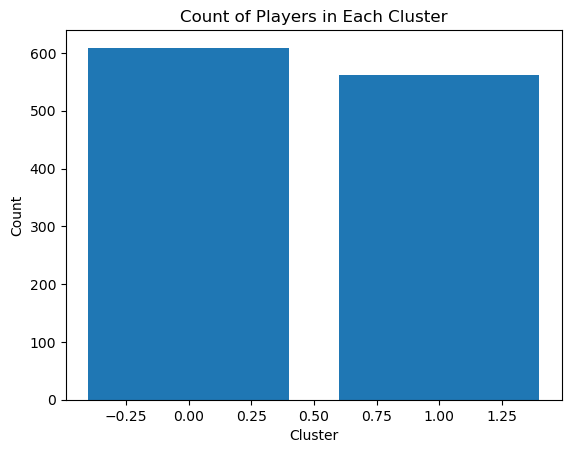

In [31]:
# Count the number of players in each cluster
cluster_counts = df_zscore_mean['Cluster'].value_counts()

# Plot the counts as a bar chart
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Count of Players in Each Cluster')
plt.show()

mapping clusters to players

In [32]:
# Create a dictionary mapping player names to their clusters
name_to_cluster = df_zscore_mean.set_index('Name')['Cluster'].to_dict()

# Map the clusters to the df_zscore DataFrame
df_zscore['Cluster'] = df_zscore['Name'].map(name_to_cluster)

df with age for groupby

In [46]:
df_zscore_age = df_zscore.copy()
df_zscore_age['Age'] = df['Age']

individual precent change
<br>
<small > look at the precent change for each player comapared to there own previous season

In [47]:
wrc_change_df = df_zscore_age.copy()
wrc_change_df['wRC+ Change'] = df_zscore_age.groupby('Name')['wRC+'].pct_change() * 100

mean by cluster, age

In [52]:
# Initialize an empty DataFrame to store cluster means by age
cluster_means_age = pd.DataFrame()

# Loop through each group of Age and Cluster
for (age, cluster), group in df_zscore_age.groupby(['Age', 'Cluster']):
    weighted_means = {}
    for col in group.select_dtypes(include=[np.number]).columns:
        if col != 'PA':
                weighted_means[col] = np.average(group[col], weights=group['PA'])
    weighted_means['Age'] = age
    weighted_means['Cluster'] = cluster
    cluster_means_age = pd.concat([cluster_means_age, pd.DataFrame([weighted_means])], ignore_index=True)

cluster_means_age = cluster_means_age.sort_values(by=['Age', 'Cluster']).reset_index(drop=True)

mean of change player for player in cluster

In [61]:
wrc_change_indiv = pd.DataFrame()
cluster_z = wrc_change_df.dropna()
wrc_change_indiv  = cluster_z.groupby(['Age', 'Cluster']).apply(
	lambda group: np.average(group['wRC+ Change'], weights=group['PA'])
)
wrc_change_indiv  = wrc_change_indiv.reset_index()
wrc_change_indiv = wrc_change_indiv.rename(columns={'level_0': 'Age', 'level_1': 'Cluster'})
wrc_change_indiv  = wrc_change_indiv.sort_values(['Cluster', 'Age'])

wrc_change_indiv['y/y wrc+'] = cluster_means_age.groupby('Cluster')['wRC+'].pct_change() * 100

C:\Users\dalto\AppData\Local\Temp\ipykernel_26712\1392026394.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wrc_change_indiv  = cluster_z.groupby(['Age', 'Cluster']).apply(


mean by age

In [ ]:
def mean_age_player(group):
        avg = np.average(group, weights=group.index.map(lambda x: df_zscore_age.loc[x, 'PA']))
        return avg

age averages

In [ ]:
age_values = pd.DataFrame()
for col in df_zscore_age.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  
        age_mean = df_zscore_age.groupby('Age')[col].apply(mean_age_player)
        age_values[col] = age_mean
age_values = age_values.reset_index(drop=True)
age_values['Age'] = round(age_values['Age'])

wrc+, by cluster, by age
<br>
<small> thanks gemeni for smoothing

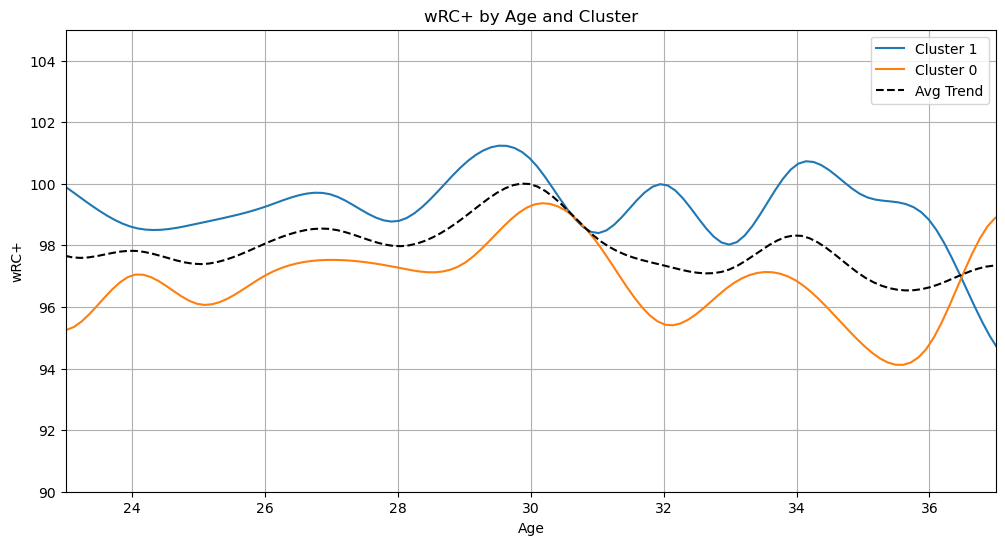

In [25]:
from scipy.interpolate import make_interp_spline
import numpy as np

# global averages
global_means = age_values[['Age','wRC+']]

# Plot wRC+ by age for each cluster
plt.figure(figsize=(12, 6))
for cluster in df_zscore_age['Cluster'].unique():
    cluster_data = cluster_means_age.loc[cluster_means_age['Cluster'] == cluster].set_index('Age')['wRC+']
    ages = cluster_data.index.get_level_values('Age')
    values = cluster_data.values
    # Smooth the trend line
    if len(ages) > 3:  # Ensure enough points for smoothing
        spline = make_interp_spline(ages, values, k=3)
        smooth_ages = np.linspace(ages.min(), ages.max(), 200)
        smooth_values = spline(smooth_ages)
        plt.plot(smooth_ages, smooth_values, label=f'Cluster {cluster}')
    else:
        plt.plot(ages, values, label=f'Cluster {cluster}')

# Smooth the global average trend line
ages = global_means['Age']
values = global_means['wRC+']
spline = make_interp_spline(ages, values, k=3)
smooth_ages = np.linspace(ages.min(), ages.max(), 200)
smooth_values = spline(smooth_ages)
plt.plot(smooth_ages, smooth_values, label='Avg Trend', linestyle='--', color='black')

plt.xlabel('Age')
plt.xlim(23, 37)
plt.ylim(90, 105)
plt.ylabel('wRC+')
plt.title('wRC+ by Age and Cluster')
plt.legend()
plt.grid(True)
plt.show()

diffrence in change y/y

In [ ]:


# global mean and cluster wrc+
cluster_wrc = cluster_means_age[['Age', 'Cluster', 'y/y wrc+']]
cluster_wrc = cluster_wrc.merge(global_means, on='Age', how='outer')
cluster_wrc = cluster_wrc.drop(columns=['wRC+'])


# sort
cluster_wrc = cluster_wrc.sort_values(['Cluster', 'Age'])
cluster_wrc['diff'] = cluster_wrc['y/y global'] - cluster_wrc['y/y wrc+']
cluster_wrc.head()


C:\Users\dalto\AppData\Local\Temp\ipykernel_26712\4021826687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_means['y/y global'] = global_means['wRC+'].pct_change() * 100


,Age,Cluster,y/y wrc+,y/y global,diff
1,20.0,0,NaN,-11.291156,NaN
3,21.0,0,-6.278053,-3.783230,2.494822
5,22.0,0,-1.196401,-0.511328,0.685074
7,23.0,0,-1.589503,-1.324142,0.265361
9,24.0,0,1.870046,0.175493,-1.694553
